## Imports

In [143]:
from __future__ import annotations

import math
from typing import Literal, Iterable

from PIL import Image

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

# pytorch with gpu
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("GPU is available and being used")
else:
    DEVICE = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


## Helper Functions

In [144]:
def visualize(X: torch.Tensor, y: torch.Tensor, class_names: Iterable[str], shape: tuple[int, int]) -> plt.Figure:
    # get images (first n)
    data = [X[i] for i in range(shape[0] * shape[1])]
    targets = [y[i] for i in range(shape[0] * shape[1])]
    
    # matplotlib OOP setup
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1])
    fig.set_size_inches(1.5 * shape[1], 1.5 * shape[0])

    for i in range(shape[0] * shape[1]):
        axes.flat[i].set_axis_off()

        axes.flat[i].set_title(class_names[targets[i]])
        axes.flat[i].imshow(data[i], cmap='gray')

## Torchvision Utilities
* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - datasets and data loading functions for computer vision
* `torchvision.models` - pretrained computer vision modes 
* `torchvision.transforms` - functions for image manipulation to be suitable for use with neural networks
* `torch.utils.data.Dataset` - base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Python iterable over a dataset for memory efficiency

## Load Computer Vision Dataset

In [222]:
train = datasets.FashionMNIST(root='./data/FashionMNIST/train/',
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)

test = datasets.FashionMNIST(root='./data/FashionMNIST/test/',
                                   train=False,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)

train_data, test_data = train.data, test.data
train_targets, test_targets = train.targets, test.targets

train_samples, test_samples = len(train), len(test)
classes, n_classes = train.classes, len(train.classes)
img_width, img_height = train_data[0].size()

## Visualize Data

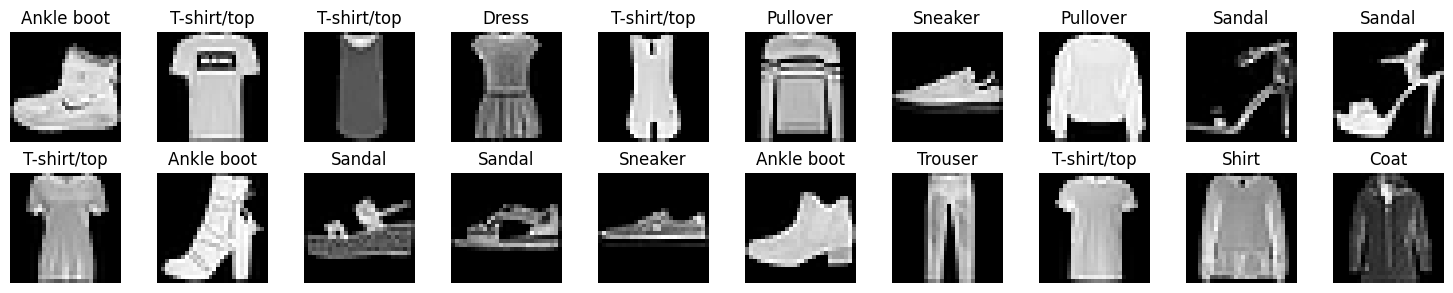

In [223]:
visualize(train_data, train_targets, classes, (2, 10))
plt.tight_layout(w_pad=0)

## Data Preparation
Convert the data from type `PyTorch Dataset` into a Python iterabe with `Python DataLoader` in order to batch our data.
- Batching is more computationally and memory efficient. Our computer hardware may not be able to store, in this case, 60,000 images at once, so it is broken down into batches of 32 or so images.
- This also allows a neural network to update its gradients multiple times per epoch.

In [224]:
BATCH_SIZE = 32

# convert datasets to dataloaders
train_dataloader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
test_dataloader = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=True,
                             collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))

## **Baseline** `Convolutional Neural Network (CNN)`

In [225]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: tuple[int, int], hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self._loss_fn: nn.modules.loss._Loss = None
        self._optimizer: torch.optim.Optimizer = None

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.Softmax(1)
        )
        self.layer_stack = nn.DataParallel(self.layer_stack)

    def compile(self, loss_fn: nn.modules.loss._Loss, optimizer: torch.optim.Optimizer) -> None:
        self._loss_fn = loss_fn
        self._optimizer = optimizer

    def fit_loader(self, dataloader: DataLoader, epochs: int):
        # iterate over epochs
        for epoch in range(epochs):
            epoch_loss = 0

            # iterate over batches
            batched_data = iter(dataloader)
            while True:
                try:
                    data, targets = next(batched_data)

                    # get prediction
                    y_logits = self(data)
                    y_pred = torch.argmax(y_logits)

                    # calculate loss
                    loss = self._loss_fn(y_logits, targets)
                    epoch_loss += loss

                    # backpropagation & gradient descent
                    self._optimizer.zero_grad()
                    loss.backward()
                    self._optimizer.step()

                except StopIteration:
                    break

            print(f'Mean Loss: {epoch_loss / len(batched_data)}')

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        z = self.layer_stack(X)

        return z

In [226]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from torch.backends import cudnn, cuda

cudnn.benchmark = True
cuda.matmul.allow_tf32 = True
cudnn.allow_tf32 = True
cudnn.deterministic = False
torch.compile(mode='reduce-overhead')

<function torch.compile.<locals>.fn(model: Callable)>

In [227]:
# build model with 1 hidden layer
model_0 = FashionMNISTModelV0(
    input_shape=img_width * img_height, 
    hidden_units=128,
    output_shape=n_classes
)
model_0 = model_0.to(DEVICE)
model_0 = model_0.cuda()

In [228]:
model_0.compile(nn.CrossEntropyLoss(), torch.optim.SGD(model_0.parameters(), 0.6))
model_0.fit_loader(train_dataloader, epochs=10)

Mean Loss: 1.7093322277069092
Mean Loss: 1.6643675565719604
Mean Loss: 1.6403889656066895
Mean Loss: 1.6323879957199097
Mean Loss: 1.629983901977539
Mean Loss: 1.6250929832458496
Mean Loss: 1.6239027976989746
Mean Loss: 1.6237268447875977
Mean Loss: 1.620776891708374
Mean Loss: 1.6235840320587158


In [177]:
device = torch.device("cuda:0")
torch.tensor([1, 1]).to(device)

tensor([1, 1], device='cuda:0')

In [176]:
a = 0
b =iter(train_dataloader)

while True:
    print(a)
    print(type(torch.tensor(next(b))))
    a += 1

0


ValueError: only one element tensors can be converted to Python scalars

In [178]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

In [182]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1660 Ti', major=7, minor=5, total_memory=6143MB, multi_processor_count=24)